In [328]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [329]:

filepath = "jokes.txt"
with open(filepath) as f:
    jokes_text = f.read()
print(jokes_text[:300])

"Automatic" simply means that you cannot repair it yourself.

90% of everything is crud.

A Project Manager is like the madam in a brothel. His job is to see
that everything comes off right.

A Smith & Wesson always beats four aces.

A bird in hand is safer than one overhead.

A bird in the hand is 


In [330]:
import string
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in jokes_text]
corpus[:10]

jokes_text= corpus

### Tokenizacion del texto

In [331]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(jokes_text)

### Probar la tokenizacion

In [332]:

# probamos la palabra
tokenizer.texts_to_sequences(["hand"])

[[10, 5, 7, 13]]

### Probar el inverso

In [333]:
tokenizer.sequences_to_texts([[10, 5, 7, 13]])

['h a n d']

In [334]:
# numero de caracteres distintos
max_id = len(tokenizer.word_index) 

# cantidad total del caracteres
dataset_size = tokenizer.document_count

print("Elementos distintos",max_id)
print("Cantidad de elementos",dataset_size)

Elementos distintos 36
Cantidad de elementos 47809


### Crear el Train-Set usando las Funciones de NLP

In [335]:
[encoded] = np.array(tokenizer.texts_to_sequences([jokes_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [336]:
# se define que las cadenas son de 100 caracteres con 1 caracter de shift
n_steps = 100
window_length = n_steps + 1 # tamano de la ventana
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

# se generan las cadenas planas
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [337]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 30

encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []

for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)

    dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda x_train, y_train: (tf.one_hot(x_train, depth=max_id), y_train))
dataset = dataset.prefetch(1)

# se revisan los tamanos de los tensores generados
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(30, 100, 36) (30, 100)


In [338]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [342]:
# arquitecturta
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation="softmax"))
])

# compilacion y entrenamiento
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=100,
                    callbacks=[ResetStatesCallback()])

Epoch 1/100
14/14 [==============================] - 7s 220ms/step - loss: 3.4877
Epoch 2/100
14/14 [==============================] - 3s 223ms/step - loss: 3.0000
Epoch 3/100
14/14 [==============================] - 4s 273ms/step - loss: 2.9108
Epoch 4/100
14/14 [==============================] - 4s 291ms/step - loss: 2.8696
Epoch 5/100
14/14 [==============================] - 4s 298ms/step - loss: 2.8111
Epoch 6/100
14/14 [==============================] - 4s 302ms/step - loss: 2.7159
Epoch 7/100
14/14 [==============================] - 4s 301ms/step - loss: 2.6220
Epoch 8/100
14/14 [==============================] - 4s 293ms/step - loss: 2.5515
Epoch 9/100
14/14 [==============================] - 4s 273ms/step - loss: 2.5063
Epoch 10/100
14/14 [==============================] - 4s 277ms/step - loss: 2.4772
Epoch 11/100
14/14 [==============================] - 4s 279ms/step - loss: 2.4445
Epoch 12/100
14/14 [==============================] - 4s 274ms/step - loss: 2.4291
Epoch 13/100


14/14 [==============================] - 4s 287ms/step - loss: 1.7244
Epoch 100/100
14/14 [==============================] - 4s 286ms/step - loss: 1.7151


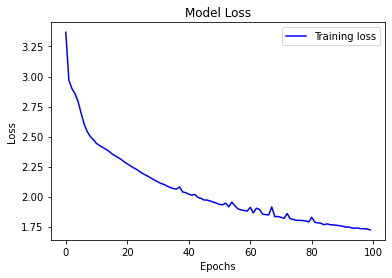

In [343]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")

plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [344]:
# esto es un super hack!
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

stateless_model.build(tf.TensorShape([None, None, max_id]))
stateless_model.set_weights(model.get_weights())

### Save the model

In [345]:
model = stateless_model

# Guardar el Modelo
model.save('Jokes_model.h5')

## Generacion de Texto

In [346]:
model = keras.models.load_model('Jokes_model.h5')

In [347]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(jokes_text)
max_id = len(tokenizer.word_index) 
max_id

36

In [348]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [349]:
X_new = preprocess(["my nam"])
X_new.shape

TensorShape([1, 6, 36])

In [350]:
#model = keras.models.load_model('Jokes_model.h5')
Y_pred = model.predict_classes(X_new)
print(Y_pred)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # primera oracion ultimo caracter.

[[4 0 5 3 2 1]]


'e'

In [351]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [365]:
def complete_text(text, n_chars=20, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [391]:
print(complete_text("the tire dog ", temperature=0.6))

the tire dog in anyone like to to


In [390]:
print(complete_text("son of the ", temperature=1))

son of the most rays ad tuke it


In [399]:
print(complete_text("Dont mess with ", temperature=1))


Dont mess with 1w when fasts

from 
